In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import torch
import h5py
import torch.fft
import os
import numpy as np

from filter import (
    create_1d_gaussian_filter,
    create_2d_gaussian_filter,
    apply_gaussian_filter,
    adaptive_kspace_filter,
    wavelet_kspace_filter,
    svd_kspace_filter,
)
from utils import ifft3d, subtract_kspace
from plot import (
    plot_coil_images,
    plot_recon_comparison,
    plot_recon,
    interactive_plot,
)
from snr import process_images

In [3]:
dataset_path = "/gpfs/data/karczmar-lab/hyperfast/9127-837-hyperfast/wa_07022024_1006375_9_2_wip_dyn_ethrive_ufast_bv1.6s_ldV4_mix0_stack0.h5"
phillips_recon_path = (
    "/gpfs/data/karczmar-lab/hyperfast/9127-837-hyperfast/IMG_SENSE.mat"
)
precon_recon_path = (
    "/gpfs/data/karczmar-lab/hyperfast/9127-837-hyperfast/precon_recon.h5"
)

n_subtract = 4
timepoint = 21

In [4]:
with h5py.File(dataset_path, "r") as f:
    kspace = torch.from_numpy(f["kspace"][()].squeeze())
    tr = f["temporal_resolution"][()].squeeze()
with h5py.File(precon_recon_path, "r") as f:
    precon_recon = torch.from_numpy(np.flip(f["data_0_0"][()].squeeze(), axis=1).copy())
with h5py.File(phillips_recon_path, "r") as f:
    phillips_recon = torch.from_numpy(
        np.flip(f["IMG_SENSE"][()].squeeze().T, axis=1).copy()
    )

In [5]:
nx, ny, nz, nc, nt = kspace.shape
print(f"nx={nx}, ny={ny}, nz={nz}, nc={nc}, nt={nt}")
mu_x = nx // 2
mu_y = ny // 2
sigma_x = nx // 10
sigma_y = ny // 10
gaussian_filters = create_2d_gaussian_filter(nx, ny, mu_x, mu_y, sigma_x, sigma_y)

nx=172, ny=40, nz=20, nc=16, nt=65
created 2D Gaussian filter in 1e-02s


In [6]:
filtered_kspace = apply_gaussian_filter(kspace, gaussian_filters)
# filtered_kspace = wavelet_kspace_filter(
#     kspace,
#     wavelet="sym8",
#     level=3,
#     threshold_func="soft",
#     sigma=None,
#     threshold_factor=5,
# )
# filtered_kspace = svd_kspace_filter(kspace, rank=50, threshold=0.1)

s_filtered_kspace = subtract_kspace(filtered_kspace, n_subtract)
s_kspace = subtract_kspace(kspace, n_subtract)

filtered_coil_images = ifft3d(s_filtered_kspace)
coil_images = ifft3d(s_kspace)

applied filter in 0.1s
completed ifft3d in 1.38 seconds
completed ifft3d in 1.36 seconds


In [7]:
# filtered_coil_images = adaptive_kspace_filter(
#     filtered_coil_images, patch_size=7, threshold_factor=1.0e-6
# )

In [8]:
os.makedirs("plots", exist_ok=True)

Nan values detected in precon


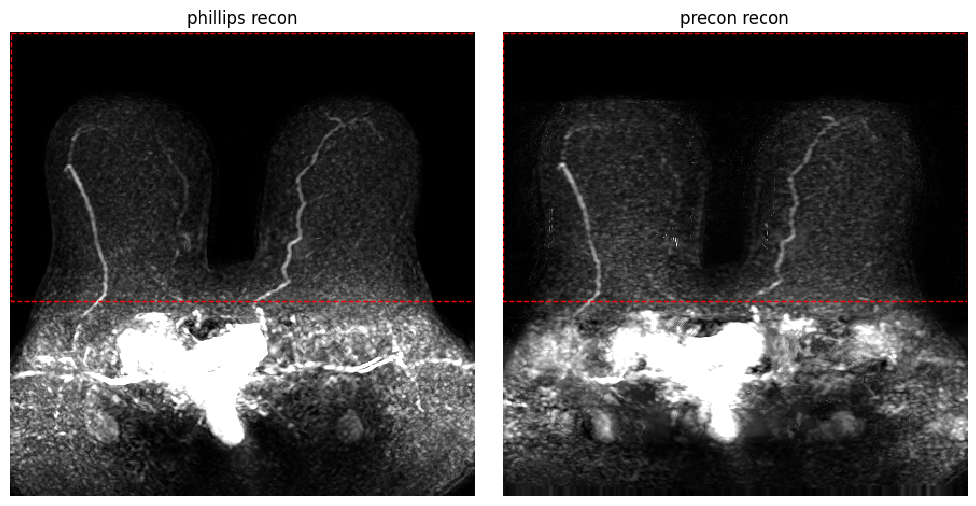

In [22]:
plot_recon_comparison(
    phillips_recon,
    precon_recon,
    21,
    tr,
    n_subtract=4,
    window=250,
)

In [9]:
interactive_plot(
    plot_coil_images,
    coil_images,
    tr,
    n_subtract=4,
    window=100,
    start_value=21,
    tag="unfiltered kspace",
)

interactive(children=(IntSlider(value=21, description='time index', max=64), Output()), _dom_classes=('widget-…

In [10]:
interactive_plot(
    plot_coil_images,
    filtered_coil_images,
    tr,
    n_subtract=4,
    window=100,
    start_value=21,
    tag="filtered kspace",
)

interactive(children=(IntSlider(value=21, description='time index', max=64), Output()), _dom_classes=('widget-…

In [11]:
interactive_plot(
    plot_recon,
    phillips_recon,
    tr,
    n_subtract=4,
    window=250,
    start_value=21,
    # lower_percentile=3,
    # upper_percentile=99.99,
)

interactive(children=(IntSlider(value=21, description='time index', max=64), Output()), _dom_classes=('widget-…

SNR for SENSE image: 6303053717214539.0
SNR for CE image: 0.3


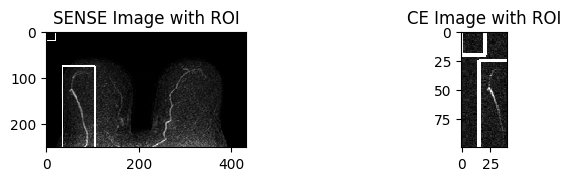

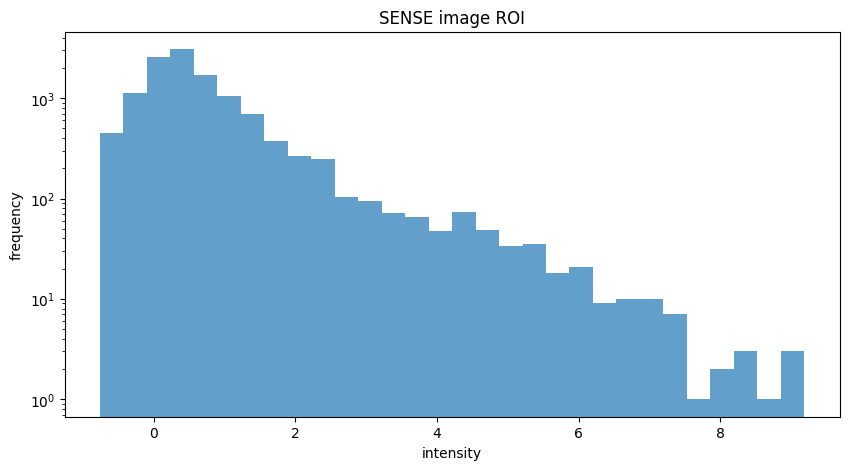

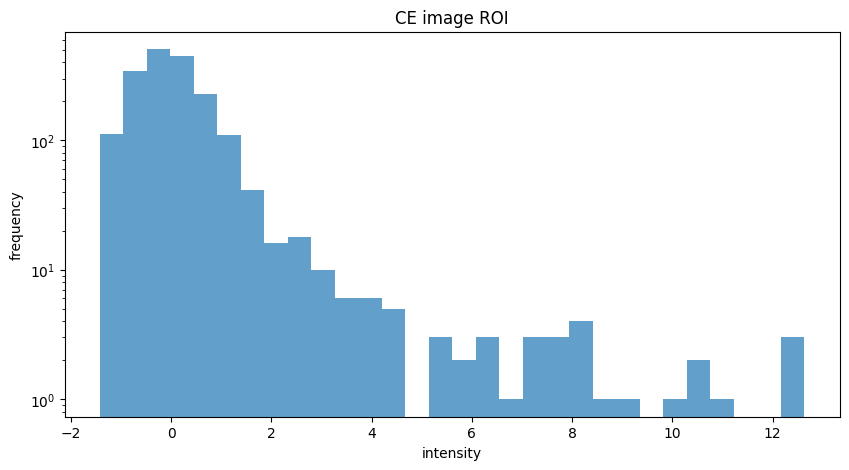

In [15]:
process_images(
    # filtered_coil_images,
    coil_images,
    phillips_recon,
    10,
    21,
    [
        (
            15,
            25,
            25,
            80,
        )
    ],
    [
        (
            35,
            75,
            70,
            200,
        )
    ],
    [(0, 0, 20, 20)],
    coil_window=100,
    recon_window=250,
    n_subtract=4,
    output_dir="plots",
)